In [5]:
import sys
import os
import datetime

from src.weather import weather_data
from src.geography import airport_locator
from src.geography import closest_town

cur_dir = os.getcwd()
root_dir = os.path.dirname(cur_dir+"/../../")
sys.path.append(root_dir)

image_dir = cur_dir + "/output/"
data_dir = cur_dir + "/data/"

In [6]:
start_date = datetime.datetime(2000, 4, 9)
end_date = datetime.datetime(2023, 4, 10)

lat, long = 38.1155, -88.4809 # Latitude and Longitude of the location
all_data = weather_data(lat, long, start_date, end_date)

all_data.head()



,date,rain,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high
0,2000-04-09 05:00:00+00:00,0.0,0.0,0.0,0.0,0.0
1,2000-04-09 06:00:00+00:00,0.0,0.0,0.0,0.0,0.0
2,2000-04-09 07:00:00+00:00,0.0,0.0,0.0,0.0,0.0
3,2000-04-09 08:00:00+00:00,0.0,0.0,0.0,0.0,0.0
4,2000-04-09 09:00:00+00:00,0.0,0.0,0.0,0.0,0.0


In [7]:
data_path = data_dir + '/airports.csv'
df2 = airport_locator(data_path, lat, long, 100)
df2.head()

,name,distance,type
0,Southern Illinois Airport,48.115483,medium_airport
1,Evansville Regional Airport,51.994546,medium_airport
2,Barkley Regional Airport,74.492573,medium_airport
3,Owensboro Daviess County Airport,76.314475,medium_airport
4,Scott AFB/Midamerica Airport,79.323855,medium_airport


In [16]:
town = closest_town(lat, long)
town = town[0]['city']

print("Closest town is: ", town)

Closest town is:  McLeansboro


/tmp/ipykernel_3356/2856808296.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cloud_coverage_data = cloud_coverage_data.append(selected_data[['date', 'cloud_cover']].rename(columns={'date': 'Hour', 'cloud_cover': 'Cloud Cover'}))
/tmp/ipykernel_3356/2856808296.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cloud_coverage_data = cloud_coverage_data.append(selected_data[['date', 'cloud_cover']].rename(columns={'date': 'Hour', 'cloud_cover': 'Cloud Cover'}))
/tmp/ipykernel_3356/2856808296.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cloud_coverage_data = cloud_coverage_data.append(selected_data[['date', 'cloud_cover']].rename(columns={'date': 'Hour', 'cloud_cover': 'Cloud Cover'}))
/tmp/ipykernel_3356/28568

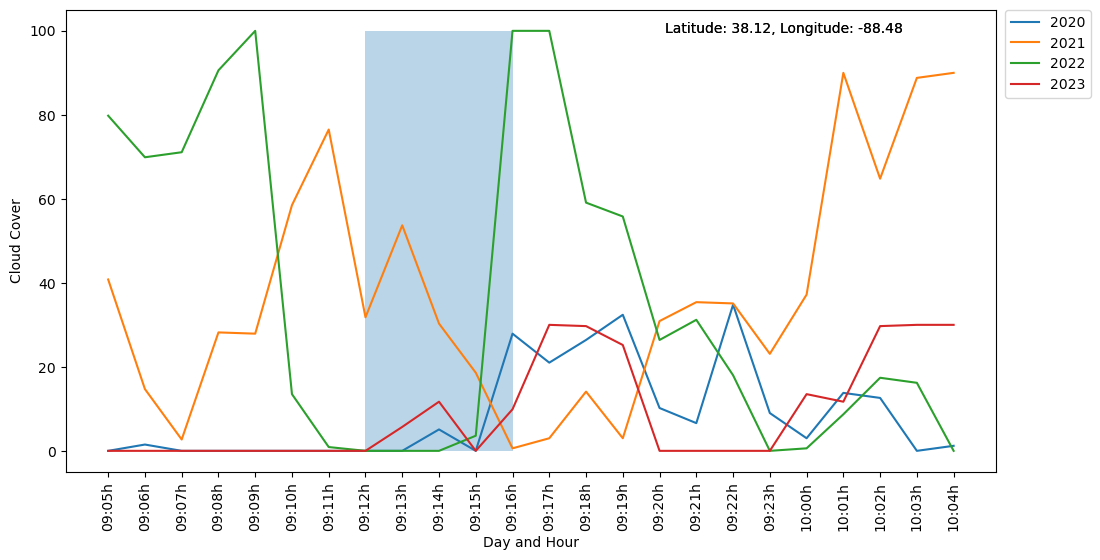

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Choose a specific date
import matplotlib.pyplot as plt

# Choose specific years and days
selected_years = np.arange(2020, 2024)
selected_days = [9, 10]

# Create an empty DataFrame to store the cloud coverage data
cloud_coverage_data = pd.DataFrame(columns=['Year', 'Day', 'Hour', 'Cloud Cover'])

# Iterate over the selected years and days
for year in selected_years:
    for day in selected_days:
        # Filter the data for the selected year and day
        selected_data = all_data[((all_data['date'].dt.year == year) & (all_data['date'].dt.day == day))]
        
        # Append the cloud coverage data to the DataFrame
        cloud_coverage_data = cloud_coverage_data.append(selected_data[['date', 'cloud_cover']].rename(columns={'date': 'Hour', 'cloud_cover': 'Cloud Cover'}))
        
# Reset the index of the DataFrame
cloud_coverage_data.reset_index(drop=True, inplace=True)

# Print the cloud coverage data
#print(cloud_coverage_data)

# Filter the data for the selected date
#selected_data = all_data[((all_data['date'].dt.year == selected_year)& (all_data['date'].dt.day == selected_day))]
#selected_data = selected_data.sort_values(by=selected_data['date'].dt.hour.values)

# Group the data by year
grouped_data = cloud_coverage_data.groupby(cloud_coverage_data['Hour'].dt.year)

fig = plt.figure(figsize=(12, 6))

for year, group in grouped_data:
    x = group['Hour'].dt.strftime('%d:%Hh')  # Format the x-axis as day:hour
    plt.plot(x, group['Cloud Cover'], label=str(year))

plt.xlabel('Day and Hour')
plt.ylabel('Cloud Cover')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
# Rotate the x-axis labels by 90 degrees
plt.xticks(rotation=90)

# Get the x values for the shaded area
x_values = grouped_data.get_group(2022)['Hour'].dt.strftime('%d:%Hh')

# Set the start and end indices for the shaded area
start_index = x_values.tolist().index('09:12h')
end_index = x_values.tolist().index('09:16h')

# Shade the area between the start and end indices
plt.fill_between(x_values[start_index:end_index+1], 0, 100, alpha=0.3)

# Add latitude and longitude to the plot
plt.text(0.9, 0.95, f'Latitude: {lat:.2f}, Longitude: {long:.2f}', transform=plt.gca().transAxes, ha='right')
plt.text(0.9, 0.95, f'Latitude: {lat:.2f}, Longitude: {long:.2f}', transform=plt.gca().transAxes, ha='right')

# Draw a rectangle around the latitude and longitude
#rect = plt.Rectangle((0.98, 0.009), 0., 0.03, fill=False, edgecolor='red', linewidth=2)
#plt.Rectangle
#plt.gca().add_patch(rect)
fig.savefig(image_dir + '/cloud-cover-%s.png'%town,
           dpi=600,format='png',bbox_inches='tight')
plt.show()



# Requesting Weather Data

# Finding the nearest town

# Nearest Airports

# Modeling the Path of Totality

In [18]:
import numpy as np

# Data points
g0 = [28.8669, -100.5548]
g1 = [32.5251, -96.4035]
g2 = [40.3839, -84.3683]
g3 = [41.2172, -82.6484]
g4 = [46.0759, -68.8376]
g5 = [32.3553, -96.6073]

# Latitude values
latitudes = [g0[0], g1[0], g2[0], g3[0], g4[0]]

# Longitude values
longitudes = [g0[1], g1[1], g2[1], g3[1], g4[1]]

# Fit a polynomial curve
coefficients = np.polyfit(latitudes, longitudes, deg=2)

# Define the fitted curve as a function of latitude
def fitted_curve(latitude):
    return coefficients[0] * latitude**2 + coefficients[1] * latitude + coefficients[2]

# Test the fitted curve
latitude = lat
longitude = fitted_curve(latitude)
print(f"The longitude for latitude {latitude} is {longitude}")


The longitude for latitude 50.0 is -55.96540480609592


In [19]:
latitude = 40.4018
longitude = fitted_curve(latitude)
print(f"The longitude for latitude {latitude} is {longitude}")

The longitude for latitude 40.4018 is -84.11839149521218


In [20]:
from geopy.distance import geodesic

# Define the coordinates of the two points
point1 = (40.4018, -84.11839149521218)  # For example, (40.748817, -73.985428) for the Empire State Building
point2 = (40.4018, -84.3263)  # For example, (51.5074, -0.1278) for London

# Calculate the distance
distance = geodesic(point1, point2).miles  # or .miles

print(f"The distance between the two points is {distance} miles.")

The distance between the two points is 10.966957355892891 miles.


In [ ]:
import geopy.distance
import numpy as np

def calculate_shortest_distance(fitted_curve, longitude, latitude):
    # Calculate the distance from the fitted curve to the given longitude and latitude
    distances = []
    for point in fitted_curve:
        point_longitude, point_latitude = point
        distance = geopy.distance.geodesic((latitude, longitude), (point_latitude, point_longitude)).miles
        distances.append(distance)
    
    # Find the shortest distance
    shortest_distance = np.min(distances)
    
    return shortest_distance



In [24]:
from geopy.distance import geodesic
import numpy as np

# Example function for the curve: latitude as a function of longitude
# This is just an example; replace it with your actual function


# Point from which we want to find the shortest distance to the curve
point = (37.3912, -89.6707)   # (latitude, longitude)

# Generate sample points along the curve
latitudes = np.linspace(25, 50, 1000)  # Sample 1000 points between -180 and 180 degrees
longitudes = fitted_curve(latitudes)

# Calculate distances and find the minimum distance
min_distance = float('inf')
closest_point = None
for lon, lat in zip(longitudes, latitudes):
    curve_point = (lat, lon)
    distance = geodesic(point, curve_point).miles
    if distance < min_distance:
        min_distance = distance
        closest_point = curve_point

print(f"Shortest distance is {min_distance} miles to the point {closest_point}.")


Shortest distance is 15.842545776033543 miles to the point (37.58758758758759, -89.82026835752276).


In [14]:
point, np.amin(longitudes), np.amax(longitudes)

((50.0, -88.4809), -101.15785046483651, -55.96540480609592)

# Modeling Time of the Eclipse

In [26]:
# Data points
g0, t0 = [29.2903, -100.0895], 12*60+11
g1, t1 = [28.8388, -100.5692], 12*60+10
g2, t2 = [46.2784, -67.8185], 15*60+22-2*60 
g3, t3 = [37.5091, -89.4882], 12*60+42

distance02, distance13 = geodesic(g0, g2).miles, geodesic(g1, g3).miles
(t2-t0)/distance02, (t3-t1)/distance13


(0.033860117135815965, 0.03653247238024017)

In [ ]:
# Latitude values
latitudes = [g0[0], g1[0], g2[0], g3[0], g4[0]]

# Longitude values
longitudes = [g0[1], g1[1], g2[1], g3[1], g4[1]]

# Fit a polynomial curve
coefficients = np.polyfit(latitudes, longitudes, deg=2)

# Define the fitted curve as a function of latitude
def fitted_curve(latitude):
    return coefficients[0] * latitude**2 + coefficients[1] * latitude + coefficients[2]